# A detailed look at Minor Planets in the Solar System using Python and large datasets

I've been using the Minor Planet Center MPCORB file any pyephem to work out asteroid positions for observing for a while now. But recently came across a [notebook](https://github.com/skyfielders/astronomy-notebooks) from the pyephem maintainer, Brandon Rhodes, where he uses python to visualise some aspects of numbered asteroids. So in this notebook I want to look at visualising some more properties of the minor planets in our Solar System. I'll be using some of Brandons code and ideas here too.

This will be a mix of astronomy any python. So if you are not interested in the python then just skip the code bits :)


Firstly we use ipython magic to import pylab, this loads numpy and matplotlib to work interactively.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We're going to use the **ephem** python library (pyephem) for some astronomy routines. 

This is based on the Xephem software that was initially released in 1993 and is a powerful planetarium tool for UNIX systems. And has been made available for use in python by Brandon Rhodes [github-link]

e.g. given an minor planets orbit and a date, work out its distance from the sun and it's angle.

In [2]:
import ephem
tau = pi * 2.0

In [3]:
# Set up Matplotlib fonts for a presentation
font = {'weight' : 'bold',
        'size'   : 12}
axes = {'labelsize' : 24}

matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)

# Minor Planets

The [Minor Planet Center](http://www.minorplanetcenter.net/) has a freely downloadable file, updated regularly, [MPCORB.DAT](http://www.minorplanetcenter.net/iau/MPCORB.html) that is updated aproximately daily with the orbits of all known minor planets.

It looks like this:
<pre>
Des'n     H     G   Epoch     M        Peri.      Node       Incl.       e     
00001    3.34  0.12 K156R 138.66222   72.65410   80.32720   10.59230  0.0757825

     n           a        Reference #Obs #Opp    Arc    rms  Perts   Computer
0.21402349   2.7679724  0 MPO337239  6555 108 1802-2015 0.60 M-v 30h MPCLINUX   0000      (1) Ceres 20150428
</pre>

**H & G** are used to estimate magnitute see http://www.britastro.org/asteroids/dymock4.pdf

![Orbital Elements](images/500px-Orbit1.svg.png) _image from Wikipedia page on Orbital Elements_

Currently there are 688614 minor planets listed in the database. In recent years large surveys have greatly increased the number of known minor planets.

## Loading the MPCORB.DAT file

The MPCORB.DAT file is reasonably clean however there are occasionally issues with it containing for exmaple empty lines and duplicate entries. Taking care of the empy lines is easy, in order to take care of duplicates we keep an onrdered list of the designations already loaded and use bisect to check if we are attepting to load a duplicate. Basic python list searching ( if x in list ) gets very slow on large lists, bisect is far faster but we must ensure we keep the list ordered in order for it to work.

MPCORB.DAT also has encoded ephocs so we need a function to convert that to a date format that pyephem understands.

We can go through the file line by line and create pyephem EllipticalBody objects for each entry.

In [4]:
from bisect import bisect_left
import re
import gzip

regex = re.compile("(.)(..)(.)(.)")

def get_mpcdata():
    ''' Open the MPC Orbital Data file of all Minor Planets
        And return it as a list of ephem bodies.
    '''
    f = gzip.open("data/MPCORB.DAT.gz",'rt')
    lines = iter(f)
    
    mpcbodies = []
    mpcindex = {}
    mpcnindex = {}
    
    # Skip through the header
    for line in f:
        if "-------------------" in line:
            break
    #next(lines)
    
    names = []
    
    for line in f:
        try:
            line = line.strip()
            if not line:
                # Blank line in MPCOrb
                continue 
    
            mpname = line[0:7].strip()
            bi = bisect_left(names, mpname)
            if bi != len(names) and names[bi] == mpname:
                #print "Dup :" + mpname + ":"
                continue
    
            b = ephem.EllipticalBody()
            try:
                b._H = float(line[8:13])        # "H"
                b._G = float(line[14:19])       # "G"
            except ValueError:
                # Object has no magnitude model data
                pass
            b._epoch = unpack_epoch(line[20:25])     # "Epoch"
            b._epoch_M = b._epoch
            b._M = float(line[26:35])       # "M"
            b._om = float(line[37:46])      # "argument of perihelion (degrees)"
            b._Om = float(line[48:57])      # "longitude of ascending node (degrees)"
            b._inc = float(line[59:68])     # "i"
            b._e = float(line[70:79])       # "e"
            b._a = float(line[92:103])      # "a"
            number = line[166:173].strip()
            if number:
                number = int(number.replace("(","").replace(")",""))
                mpcnindex[number] = mpname
            b.name = mpname
            names.insert(bi,mpname)
            mpcbodies.append(b)
            mpcindex[mpname] = len(mpcbodies) -1
            mpcnindex[number] = mpname
        except:
            print("Unknown Problem with line:" + line + ":")
            raise
    
    del(names)
    
    print('Loaded', len(mpcbodies), 'asteroids')
    return mpcbodies, mpcindex, mpcnindex

def unpack_epoch(packed):
    ''' Unpack the MPC epoch format.
    '''
    ehash = {'1': '01',
    '2': '02',
    '3': '03',
    '4': '04',
    '5': '05',
    '6': '06',
    '7': '07',
    '8': '08',
    '9': '09',
    'A': '10',
    'B': '11',
    'C': '12',
    'D': '13',
    'E': '14',
    'F': '15',
    'G': '16',
    'H': '17',
    'I': '18',
    'J': '19',
    'K': '20',
    'L': '21',
    'M': '22',
    'N': '23',
    'O': '24',
    'P': '25',
    'Q': '26',
    'R': '27',
    'S': '28',
    'T': '29',
    'U': '30',
    'V': '31'}

    matches = regex.match(packed)

    year = ehash[matches.group(1)] + matches.group(2)
    month = ehash[matches.group(3)]
    day = ehash[matches.group(4)]
    datestr = year + "/" + month + "/" + day
    return datestr

mpcbodies, mpcindex, mpcnindex = get_mpcdata()

Loaded 932790 asteroids


Given a date we can calculate the positions of all known asteroids. Specifically we're interested in their distance from the Sun, their angle and their inclination to the plane of the Solar System.

Let's look at today, Feb 13th 2020.

In [5]:
def compute_asteroid_positions(mjd, mpcbodies):
    ''' compute theta, r and phi for each body at the given date'''
    for b in mpcbodies:
        b.compute(mjd)
    theta = np.array([ b.hlon for b in mpcbodies ])
    phi = np.array([ b.hlat for b in mpcbodies ])
    r = np.array([ b.sun_distance for b in mpcbodies ])
    return theta, r, phi

mjd = ephem.Date('2020/02/13 23:00')
theta, r, phi = compute_asteroid_positions(mjd,mpcbodies)

print('First asteroid is at angle', theta[0])
print('and at distance', r[0], 'AU from the Sun')
print('at an inclination', phi[0])

First asteroid is at angle 5.212235450744629
and at distance 2.937894344329834 AU from the Sun
at an inclination -0.115488201379776


We can find out some interesting asteroids immediately from this data. For instance we can find the minor planet currently closest to the sun:
    

In [6]:
min_dist = min(r)
list_position = numpy.where(r==min_dist)[0][0]
asteroid = mpcbodies[list_position]
print("The asteroid currently closest to the sun is " + asteroid.name)
print("At a distance of " + str(min_dist) + " AU.")

The asteroid currently closest to the sun is K19Y02V
At a distance of 0.16417671740055084 AU.


And also the minor planet currently furthest from the Sun:

In [7]:
max_dist = max(r)
list_position = numpy.where(r==max_dist)[0][0]
asteroid = mpcbodies[list_position]
print("The asteroid currently farthest to the sun is " + asteroid.name)
print("At a distance of " + str(max_dist) + " AU.")

The asteroid currently farthest to the sun is K18V18G
At a distance of 125.69380187988281 AU.


When I first ran this [Eris](https://en.wikipedia.org/wiki/Eris_(dwarf_planet)) was the furthest away. Discovered in 2005 it is just smaller than Pluto after _New Horizons_ revised the size of Pluto. It is the 9th most massive body to orbit the Sun, and so is one of the most distant objects in the known Solar System.

In the years since further searches of the outer Solar System have found more objects. K18V18G is better known as 2018 VG18 https://en.wikipedia.org/wiki/2018_VG18 and is currently 19 billion km from us.

# Let's do some visualisations!

We know the angle and distance of the known minor planets, so lets plot them.

We'll add Mars, Jupiter, Saturn, Uranus and Neptune to the plot to give us a sense of scale and reference.

In [8]:
def generate_planet_positions(cls, mjd):
    ''' Returns the Planet positions suitable for plotting in a polar scatter plot'''
    planet = cls()
    dates = np.arange(mjd, mjd +2, 1.0)
    for date in dates:
        planet.compute(date)
        yield (planet.hlon, planet.sun_distance)

[None, None, 0.0, 130]

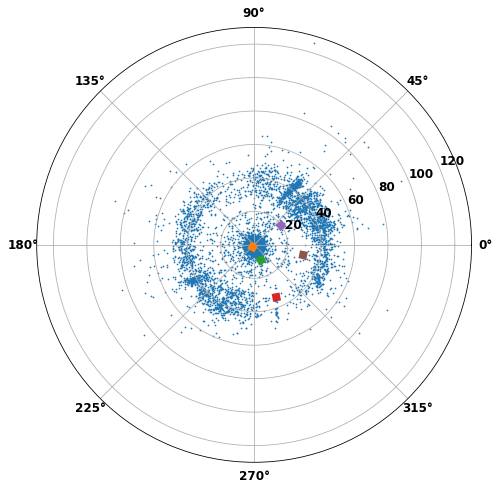

In [9]:
subplot = figure(figsize=(12, 8)).add_subplot(111, polar=True)

subplot.scatter(theta, r, s=0.5)

for cls in ephem.Jupiter, ephem.Mars, ephem.Saturn, ephem.Pluto, ephem.Uranus, ephem.Neptune:
    g = generate_planet_positions(cls, mjd)
    theta_r = np.array(list(g)).T
    subplot.plot(theta_r[0], theta_r[1], linewidth=8)

subplot.axis([None, None, 0.0, 130])

From this we can see that there is a concentration of minor planets around Mars and Jupiter (we'd expect to see minor planets in the Asteroid Belt!) and that there is also a population around 30 - 50 AU with a handful of minor planets beyond that out to almost 100 AU. With 2018 VG18 on it's own at 125AU!

We can create a heatmap to see more clearly where the minor planets are concentrated. In this image red represents the highest concentration and light blue the fewest. 

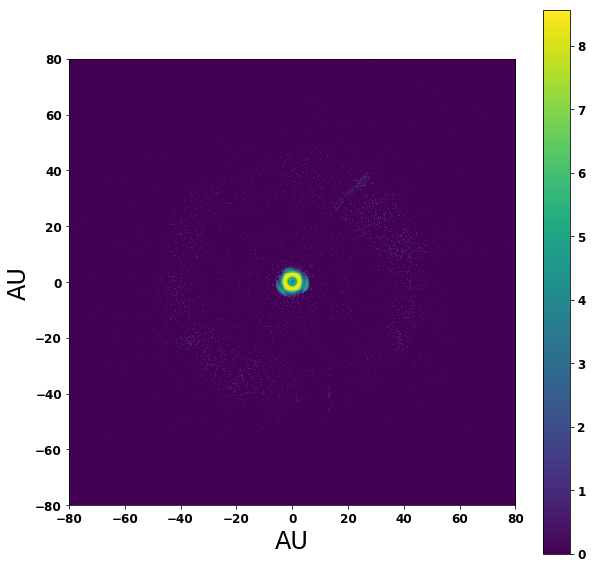

In [10]:
x =  r * cos(theta)
y = -r * sin(theta)

heatmap, xedges, yedges = np.histogram2d(
    y, x, bins=500, range=[[-80, 80], [-80, 80]])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig, ax = subplots(figsize=(10, 10))
ax.set_xlabel('AU')
ax.set_ylabel('AU')
im = ax.imshow(log(heatmap + 1.0), extent=extent)
fig.colorbar(im)

So the overwhelming majority of minor planets are within 10 AU of the Sun.

# Examining the minor planets within 10AU of the Sun

Let's draw another heatmap of the asteroids (we can call them that now!) within about 10AU, and also indicate the planet positions:

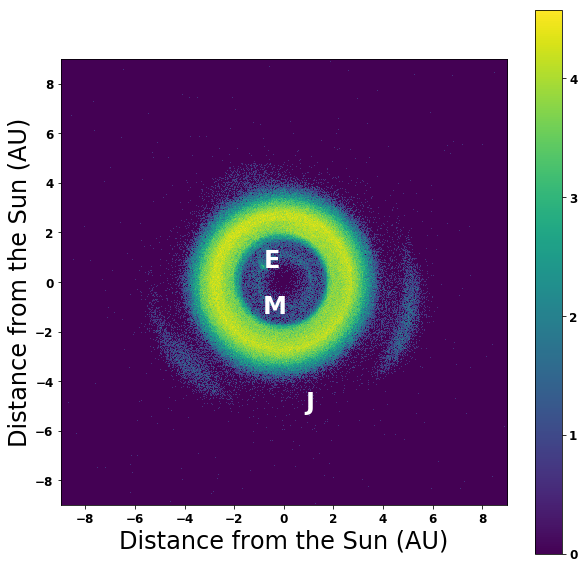

In [11]:
heatmap, xedges, yedges = np.histogram2d(
    y, x, bins=500, range=[[-9, 9], [-9, 9]])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig, ax = subplots(figsize=(10, 10))

planets = { 'J': 'Jupiter', 'M': 'Mars', 'S':'Saturn', 'E':'Sun' }

for key in planets:
    p = planets[key]
    ep = getattr(ephem, p)()
    ep.compute(mjd)
    er = ep.sun_distance
    if p == 'Sun':
        er = ep.earth_distance
    annotate(key[0], xy=(er * cos(ep.hlon), er * sin(ep.hlon)), fontsize=24, color="white")

im = ax.imshow(log(heatmap + 1.0), extent=extent)
ax.set_xlabel('Distance from the Sun (AU)')
ax.set_ylabel('Distance from the Sun (AU)')
fig.colorbar(im)

One striking thing with this image is that there appear to be two 'clouds' of asteroids in Jupiters orbit on either side of Jupiter.


# The lagrange points in Jupiters orbit.


Let's look at this visually in the data. What's the current distance from Jupiter to the Sun?

In [12]:
jupiter = ephem.Jupiter()
jupiter.compute(mjd)
print('Jupiter heliocentric distance =', jupiter.sun_distance)

Jupiter heliocentric distance = 5.211507797241211


Plot the angle (heliocentric latitudes) of all asteroids with a distance from the Sun greater than 4 AU (just far enough to ignore the main belt asteroids). We'll use the letter J again to indicate Jupiter.

Text(0, 0.5, 'Number of Asteroids')

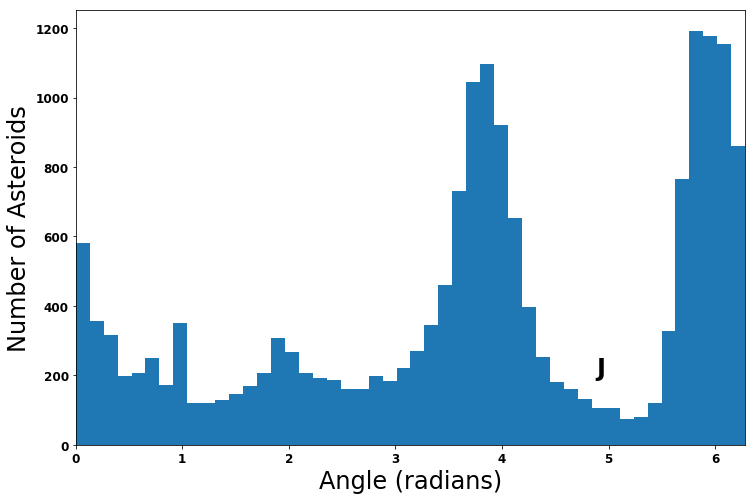

In [13]:
subplot = figure(figsize=(12, 8)).add_subplot(111)
n, bins, patches = subplot.hist(theta[r > 4], bins=48)
jpos = (jupiter.hlon, 200.0)
annotate('J', xy=jpos, fontsize=24)
axis([0.0, tau, None, None])
subplot.set_xlabel('Angle (radians)')
subplot.set_ylabel('Number of Asteroids')


The two main 'clouds' of asteroids are equidistant from Jupiter:

Looking again at a polar plot of the locations we can see that the peak of these couds corresponds to points which are equidistant from Jupiter and the Sun - The L4 and L5 lagrange points.

These groups are refered to as the Trojans and the Greeks. Those in the leading orbit are named after Greek heroes, those in the trailing orbit are named after the Heroes of Troy.

Our histogram also showed that there was a small group of asteroids that appeared at the opposide side of the sun to Jupiter, at about 0 radians.

Isolating the asteroids in that position on the image we can determine that they have a couple of common properties:
    
* Semi Major Axis between 3.7 and 4.2 AU
* Eccentricity less than 0.3
* Inclination less than about 0.07 radians (about 4 degrees)

We can select just the asteroids with these characteristics and plot them.

There are 1794 Asteroids in our group


[None, None, 0.0, 7]

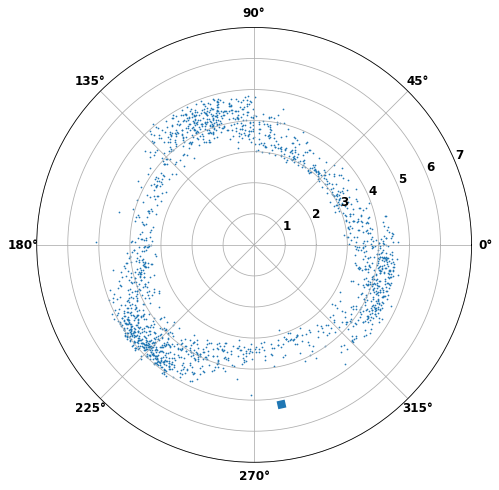

In [14]:
indeces = [mpcindex[x.name] for x in mpcbodies if x._a >3.7 and x._a <4.2 and x._e < 0.3 and x._inc < 0.07]
print("There are " + str(len(indeces)) + " Asteroids in our group")

# Construct a plot for just these asteroids
theta_2 = np.array([theta[x] for x in indeces])
r_2 = np.array([r[x] for x in indeces])

subplot = figure(figsize=(12, 8)).add_subplot(111, polar=True)
subplot.scatter(theta_2, r_2, s=0.5)

# And add Jupiter
g = generate_planet_positions(ephem.Jupiter, mjd)
theta_r = np.array(list(g)).T
subplot.plot(theta_r[0], theta_r[1], linewidth=8)

subplot.axis([None, None, 0.0, 7])

# The Hildas

Instead of finding a family of asteroids that are on the opposite side of the sun to Jupiter, we find a set of asteroids that at any time appear to make a triangle in space with concentrations around the Lagrange points and the oppoisite side to Jupiter.

These asteroids are in a 3:2 orbital resonance with Jupiter, i.e. their orbital periods are 2/3 that of jupiter. The 'points' of the triangle are where the asteroids are at their most distant from the sun (~4.2AU). Due to their resonance they will be at that maximum distance at one of the lagrange points or the third point opposite Jupiter.

Wikipedia has a good animation of the resonance https://en.wikipedia.org/wiki/Hilda_asteroid

# Hidden Gravitational gaps

So far we've looked at the current positions of asteroids, however in 1866 Daniel Kirkwood noticed that there were gaps in the semi major axis of the then known asteroids and those gaps corresponded to positions with orbital resonances with Jupiter.

Over the lifetime of the Soalr System (billion years or so) orbital resonances have played a big part in determining the stable orbits that objects are in.


Plotting a histogram of the current distances of asteroids doesn't show us much of a pattern - other than they are between Mars and Jupiter!

Text(0, 0.5, 'Number of Asteroids')

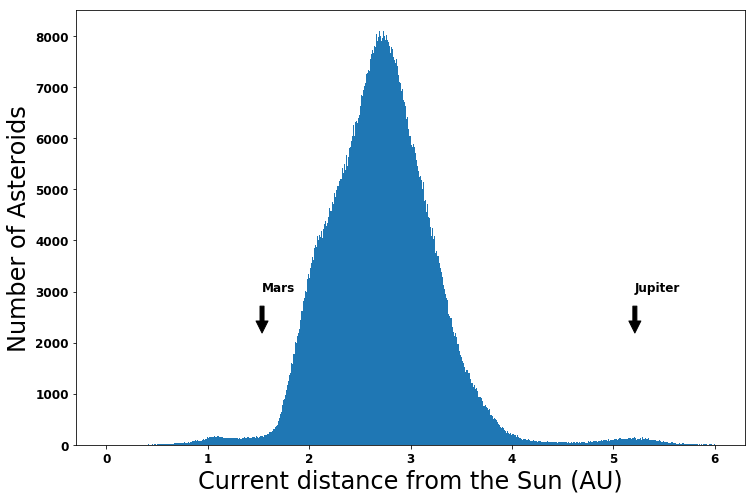

In [15]:
subplot = figure(figsize=(12, 8)).add_subplot(111)
n, bins, patches = subplot.hist(r, bins=600, range=[0, 6])
for cls in ephem.Mars, ephem.Jupiter:
    planet = cls()
    planet.compute(mjd)
    annotate(
        planet.name,
        xy=(planet.sun_distance, 2000),
        xytext=(planet.sun_distance, 3000),
        arrowprops=dict(facecolor='black', shrink=0.2),
        )
subplot.set_xlabel('Current distance from the Sun (AU)')
subplot.set_ylabel('Number of Asteroids')



But if we plot the same histogram using the semi-major axis then something interesting occurs:

Text(0, 0.5, 'Number of Asteroids')

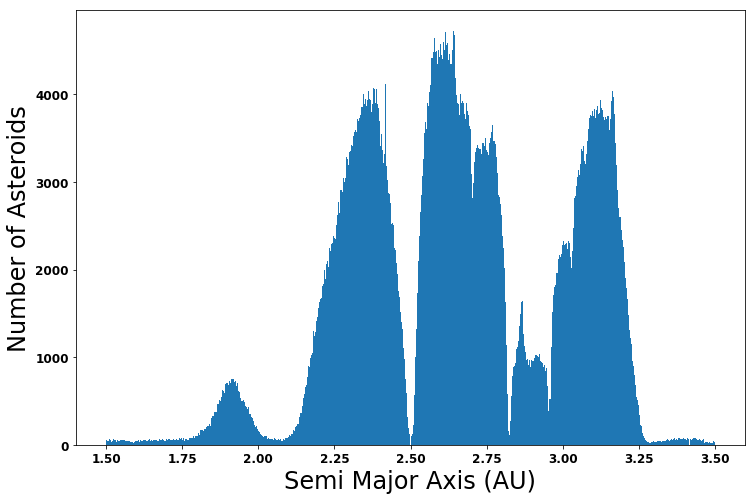

In [16]:
subplot = figure(figsize=(12, 8)).add_subplot(111)
n, bins, patches = subplot.hist([b._a for b in mpcbodies], bins=600, range=[1.5, 3.5])
subplot.set_xlabel('Semi Major Axis (AU)')
subplot.set_ylabel('Number of Asteroids')


These gaps are known as the Kirkwood Gaps. The dip at 2.5 AU fr example equates to a period of 3.95 years which is 1/3 of the period of Jupiter and asteroids in here would be at a 3:1 resonance with Jupiter. Asteroids in the regions would have unstable orbits over time and would have been ejected into more stable orbits.



# The Hungarians

The clump of asteroids on the above plot between 1.75 and 2 AU are not due to Jupiter. To learn a bit more about them we need to start thinking in 3 dimensions.

As well as looking at the Semi Major axis we need to look at the inclination. So lets plot that against the Smei Major Axis. (e denotes the group we're looking at).

[also see http://www.jpl.nasa.gov/news/news.php?feature=4678&utm_source=iContact&utm_medium=email&utm_campaign=NASAJPL&utm_content=daily20150803-1 and the paper inthe wikipedia article of the main asteroid]

Text(0, 0.5, 'Inclination (radians)')

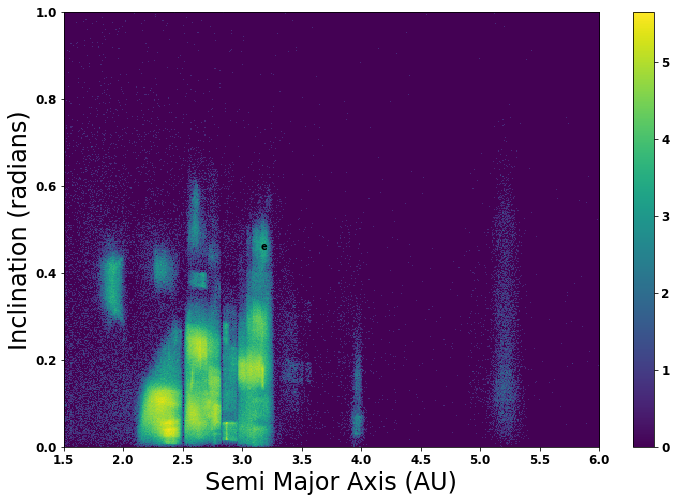

In [17]:
x=[a._a for a in mpcbodies]         
y=[float(b._inc) for b in mpcbodies]

H, xedges, yedges = np.histogram2d(x, y, bins=500, range=[[1.5,6],[0,1]])
#H, xedges, yedges = np.histogram2d(x, y, bins=500, range=[[2.5,3.5],[0,0.2]])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = subplots(figsize=(12, 8))
im = ax.imshow(log(H.transpose()[::-1] + 1.0), extent=extent, aspect="auto")
annotate('e', xy=(3.155,0.4537), fontsize=10)
fig.colorbar(im)

ax.set_xlabel('Semi Major Axis (AU)')
ax.set_ylabel('Inclination (radians)')

Our asteroid group are now distinct from the main Kirkwood groups.  
They are at an higher inclination.

This group of asteroids are known as the Hungaria family, and derive their name from their largest member 434 Hungaria.

Their characteristics are:
* Semi-major axis between 1.78 and 2.00 AU
* Orbital period of approximately 2.5 years
* Low eccentricity of below 0.18
* An inclination of 16° to 34°

May be the remains of the hypothetical E-belt asteroid population. The dispersal of most of that hypothetical E-Belt might have been caused by the outwards migration of the gas giants of the Solar System according to simulations done under the Nice model – and these dispersed E-Belt asteroids might in turn have been the impactors of the Late Heavy Bombardment.



# The Plutinos and beyond

A characteristic of Pluto is that it has a high inclination. We can extend our earlier plot to look further out into the Solar System. Colours indicate concentrations.


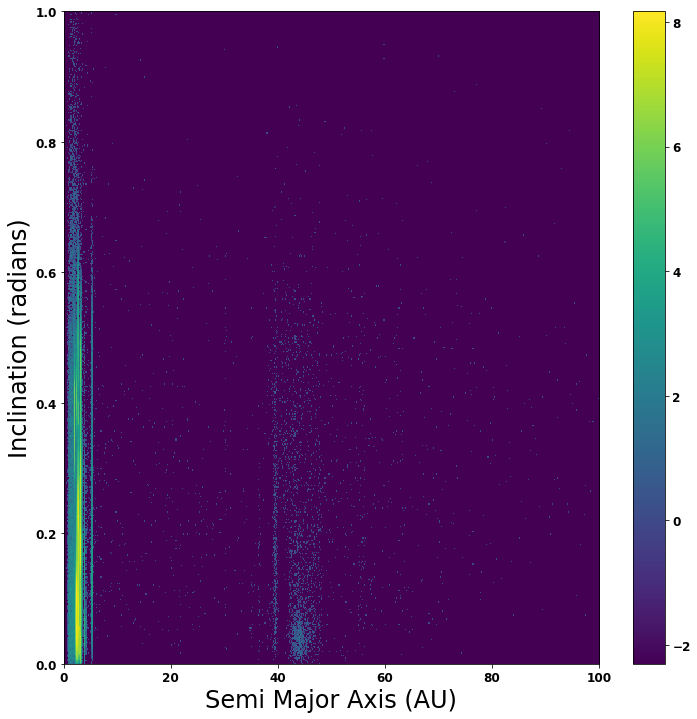

In [18]:
x=[a._a for a in mpcbodies]         
y=[float(b._inc) for b in mpcbodies]

H, xedges, yedges = np.histogram2d(x, y, bins=500, range=[[0,100],[0,1]])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = subplots(figsize=(12, 12))
im = ax.imshow(log(H.transpose()[::-1] + 0.1), extent=extent, aspect="auto")
ax.set_xlabel('Semi Major Axis (AU)')
ax.set_ylabel('Inclination (radians)')
fig.colorbar(im)

At 40 AU are the Plutinos, named after Pluto the biggest member of the group, 2:3 mean-motion resonance with Neptune. For every 2 orbits that a plutino makes, Neptune orbits 3 times. 

At 45 AU we see the Edgework Kuiper Belt.

Beyond that is a 'scattered disc' of minor planets, that includes Eris, which are usually characterised by highly eccentric orbits.

# Looking at eccintricity -v- semi major axis


TODO: Explain what that 'come tail' like structure in the plot is about.

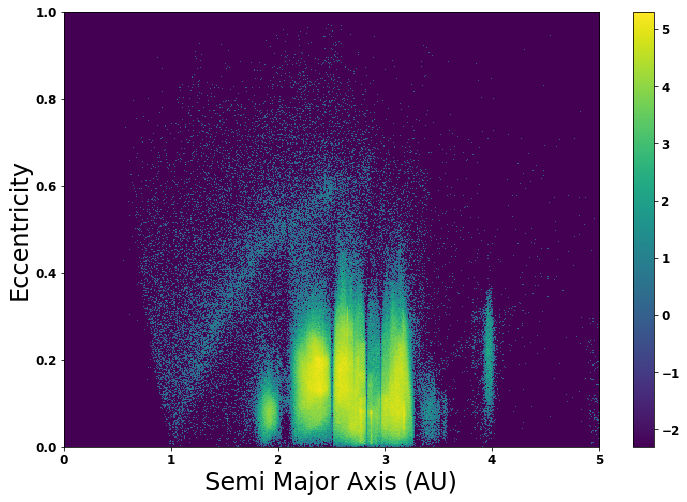

In [19]:
x=[a._a for a in mpcbodies]         
y=[float(b._e) for b in mpcbodies]

H, xedges, yedges = np.histogram2d(x, y, bins=500, range=[[0,5],[0,1]])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = subplots(figsize=(12, 8))
im = ax.imshow(log(H.transpose()[::-1] + 0.1), extent=extent, aspect="auto")
ax.set_xlabel('Semi Major Axis (AU)')
ax.set_ylabel('Eccentricity')
fig.colorbar(im)


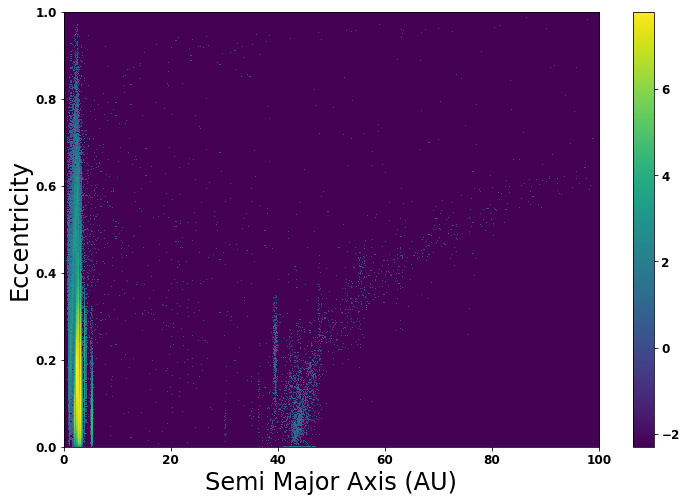

In [20]:
x=[a._a for a in mpcbodies]         
y=[float(b._e) for b in mpcbodies]

H, xedges, yedges = np.histogram2d(x, y, bins=500, range=[[0,100],[0,1]])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = subplots(figsize=(12, 8))
im = ax.imshow(log(H.transpose()[::-1] + 0.1), extent=extent, aspect="auto")
ax.set_xlabel('Semi Major Axis (AU)')
ax.set_ylabel('Eccentricity')
fig.colorbar(im)

# Proper Orbits

The proper orbital elements of an orbit are constants of motion of an object in space that remain practically unchanged over an astronomically long timescale. The term is usually used to describe the three quantities:

    proper semimajor axis (ap),
    proper eccentricity (ep), and
    proper inclination (ip).
    
To obtain proper elements for an object, one usually conducts a detailed simulation of its motion over timespans of several millions of years. Such a simulation must take into account many details of celestial mechanics including perturbations by the planets. Subsequently, one extracts quantities from the simulation which remain unchanged over this long timespan; for example, the mean inclination, eccentricity, and semi-major axis. These are the proper orbital elements. 

https://en.wikipedia.org/wiki/Proper_orbital_elements

http://asteroids.matf.bg.ac.rs/fam/properelements.php


We can use this data to have a look for relationships between these properties and look for families of objects. The families are not as obvious when we look at the Keplerian orbits from the MPCORB file. 

Here's the plot of Eccentricity versus Inclination using the Keplerian MPCORB data:

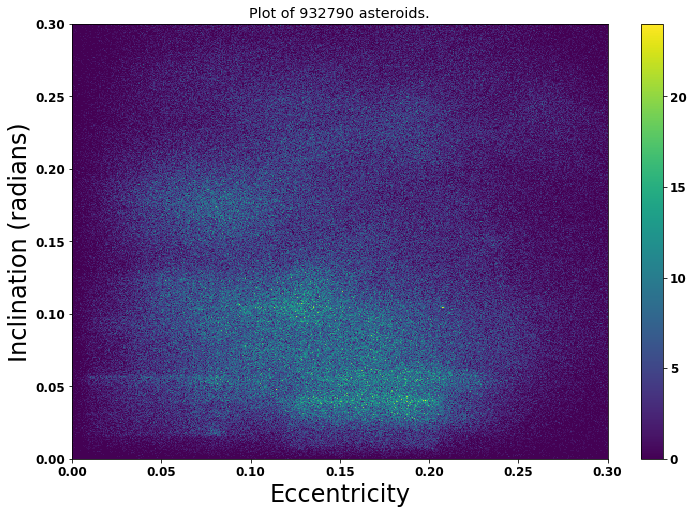

In [21]:
x=[float(b._e) for b in mpcbodies]
y=[float(a._inc) for a in mpcbodies]         

H, xedges, yedges = np.histogram2d(x, y, bins=500, range=[[0,0.3],[0,0.3]])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = subplots(figsize=(12, 8))
im = ax.imshow(H.transpose()[::-1], extent=extent, aspect="auto")
ax.set_xlabel('Eccentricity')
ax.set_ylabel('Inclination (radians)')
ax.set_title("Plot of " + str(len(x)) + " asteroids.")
fig.colorbar(im)

But when we use the proper elements we see much more distinct families:

In [22]:

def get_properdata():
    """ Extract the inclination, eccentricity and sinI from the proper data.
    """
    f = gzip.open("data/afp.pro.gz")
    lines = iter(f)

    properorbits = []
    
    for line in f:
        d = line.split()
        properorbits.append([str(int(d[0])), float(d[2]), float(d[3]), float(d[4])])

    return properorbits
        
properorbits = get_properdata()

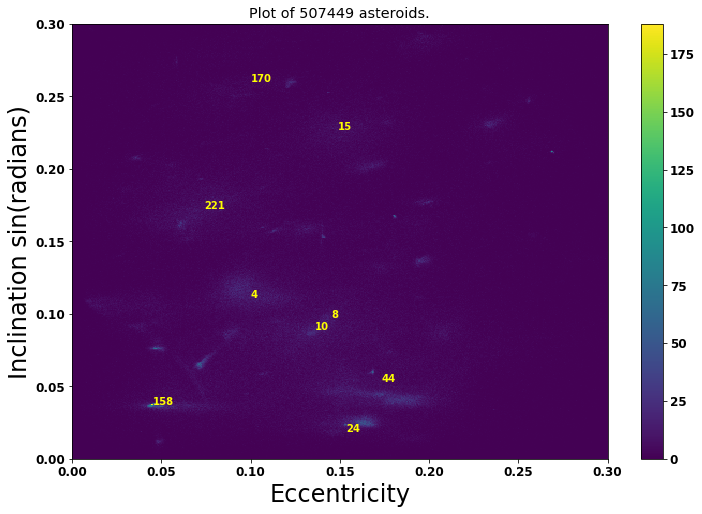

In [23]:
x=[b[2] for b in properorbits ]
y=[a[3] for a in properorbits ]         

def xypos(i):
    return [ (t[2],t[3]) for t in properorbits if t[0] == i][0]

H, xedges, yedges = np.histogram2d(x, y, bins=500, range=[[0,0.3],[0,0.3]])

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = subplots(figsize=(12, 8))
im = ax.imshow(H.transpose()[::-1], extent=extent, aspect="auto")
#ax.pcolormesh(xedges, yedges, H.T)
ax.set_xlabel('Eccentricity')
ax.set_ylabel('Inclination sin(radians)')
labels = ['44', '221', '15', '8', '10', '158', '170', '24', '4']
for l in labels:
    annotate(l, xy=xypos(l), fontsize=10, color='yellow')
ax.set_title("Plot of " + str(len(x)) + " asteroids.")
fig.colorbar(im)

And the same plot again but with some numbered asteroids in to indicate some of the families

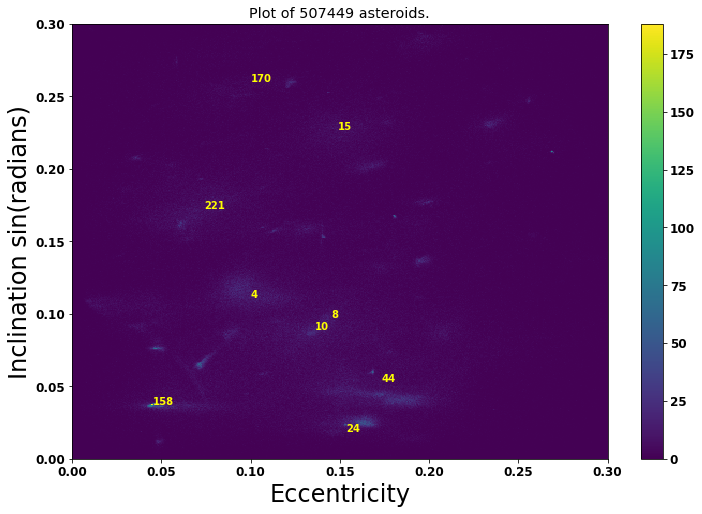

In [24]:
x=[b[2] for b in properorbits ]
y=[a[3] for a in properorbits ]         

def xypos(i):
    return [ (t[2],t[3]) for t in properorbits if t[0] == i][0]

H, xedges, yedges = np.histogram2d(x, y, bins=500, range=[[0,0.3],[0,0.3]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = subplots(figsize=(12, 8))
im = ax.imshow(H.transpose()[::-1], extent=extent, aspect="auto")
#ax.pcolormesh(xedges, yedges, H.T)
ax.set_xlabel('Eccentricity')
ax.set_ylabel('Inclination sin(radians)')
labels = ['44', '221', '15', '8', '10', '158', '170', '24', '4']
for l in labels:
    annotate(l, xy=xypos(l), fontsize=10, color='yellow')
ax.set_title("Plot of " + str(len(x)) + " asteroids.")
fig.colorbar(im)

There appears to be a high concentration of minor planet with an incilination of about 0.21 and an eccentricity of about 0.27. Wonder what they are...

We can isolate them and get their asteroid numbers and work out some properties they may share. For these the first asteroid is 1547 Nele. An unremarkable asteroid discovered in 1929. However a more rigourous dig into the data by Milani et. al. has identified this as a group of 108 asteroids. If you've made it this far and want to know more about identifying familis in the above plot have a read of https://arxiv.org/abs/1312.7702 

# Further reading

[TODO: cite properly :)  ]

Asteroid family ages. Spoto, Federica; Milani, Andrea; Knežević, Zoran, Icarus, Volume 257, p. 275-289. http://arxiv.org/abs/1504.05461

Asteroid families classification: exploiting very large data sets. Andrea Milani, Alberto Cellino, Zoran Knezevic, Bojan Novakovic, Federica Spoto, Paolo Paolicchi, Icarus, Volume 239, p. 46-73. http://arxiv.org/abs/1312.7702

Families among high-inclination asteroids. Bojan Novakovic, Alberto Cellino, Zoran Knezevic, Icarus, Volume 216, Issue 1, p. 69-81. http://arxiv.org/abs/1108.3740

http://adsabs.harvard.edu/cgi-bin/nph-ref_query?bibcode=2014Icar..239...46M&amp;refs=CITATIONS&amp;db_key=AST
Asteroid families classification: Exploiting very large datasets 
https://arxiv.org/pdf/1312.7702.pdf

